In [103]:
from nilearn import datasets, plotting, decomposition, regions, connectome
import numpy as np
import pandas as pd

In [89]:
patient_df = pd.read_csv("./patient_ids.csv")
ids = list(patient_df['ID'])

In [90]:
data = nilearn.datasets.fetch_oasis_vbm(data_dir="./data/")

In [113]:
white_matter_maps = []
labels = []
for i in ids:
    for j in range(len(data.ext_vars)):
        if (str(data.ext_vars[j][0]).split('_')[1] == i.split('_')[1]):
            white_matter_maps.append(data.white_matter_maps[j])
            labels.append(data.ext_vars[j][7])

In [94]:
# Initialize Independent Component Analysis Model
canica = decomposition.CanICA(n_components=10, mask_strategy='background')

# Fit model to WMMs
canica.fit(white_matter_maps)

/usr/local/lib/python3.9/site-packages/nilearn/signal.py:198: UserWarning: Detrending of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Detrending of 3D signal has been requested but '
/usr/local/lib/python3.9/site-packages/nilearn/signal.py:64: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/usr/local/lib/python3.9/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


CanICA(mask_strategy='background', n_components=10)

/usr/local/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


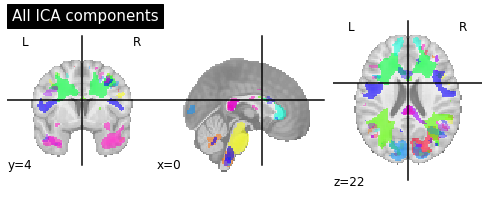

In [95]:
# Retrieve the independent components in brain space.
components_img = canica.components_img_

# Plotting all the components
plotting.plot_prob_atlas(components_img, title='All ICA components')

/usr/local/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


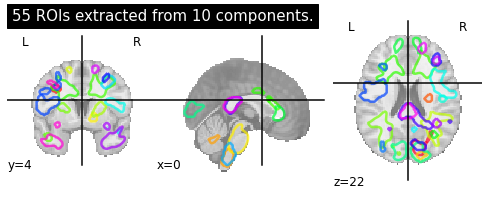

In [98]:
# Import Region Extractor algorithm from regions module
extractor = regions.RegionExtractor(components_img,standardize=True)

# Process for regions extraction
extractor.fit()

# Extracted regions are stored in regions_img_
regions_img = extractor.regions_img_

# Total number of regions extracted
n_regions = regions_img.shape[-1]

# Visualization of region extraction results
title = ('%d ROIs extracted from %d components.' % (n_regions, 10))
plotting.plot_prob_atlas(regions_img, title=title)

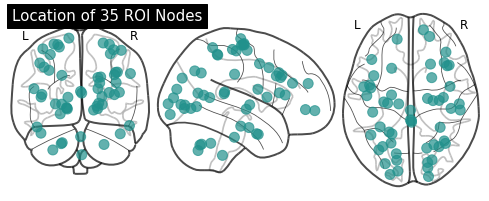

In [102]:
# Getting the center coordinates from the component decomposition to use as atlas labels
coords = plotting.find_probabilistic_atlas_cut_coords(regions_img)

# Plot ROI Nodes
title = "Location of 55 ROI Nodes"
plotting.plot_markers(np.ones(n_regions), coords, colorbar=False, title=title)

In [106]:
# Extract timeseries signals
timeseries = [extractor.transform(f) for f in white_matter_maps]

/usr/local/lib/python3.9/site-packages/nilearn/signal.py:64: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


In [107]:
# Initializing ConnectivityMeasure object with kind='correlation'
conn_measure = connectome.ConnectivityMeasure(kind='correlation')

# Generating Connectivity Matrices
conn_matrices = conn_measure.fit_transform(timeseries)

/usr/local/lib/python3.9/site-packages/sklearn/covariance/_shrunk_covariance.py:203: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.9/site-packages/sklearn/covariance/_empirical_covariance.py:88: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.9/site-packages/nilearn/signal.py:64: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '
/usr/local/lib/python3.9/site-packages/sklearn/covariance/_shrunk_covariance.py:203: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/usr/local/lib/python3.9/site-packages/sklearn/covariance/_empirical_covariance.py:88: UserWarning: Only one sample available. You 

In [108]:
for i in range(n_regions): conn_matrices[:,i,i] = 0

In [116]:
# Separating the correlation matrices between treatment and control subjects
ad_matrices, td_matrices = [], []

for i in range(len(labels)):
    if labels[i] == 1: ad_matrices.append(conn_matrices[i])
    else: td_matrices.append(conn_matrices[i])

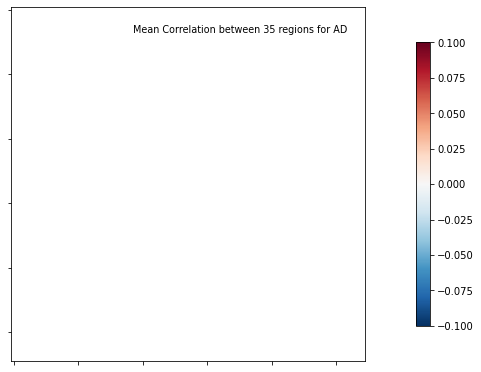

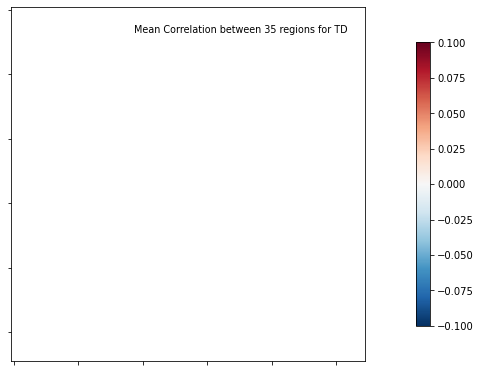

In [118]:
# Getting the mean correlation matrix across all treatment subjects
ad_mean_matrix = np.mean(ad_matrices, axis=0).reshape(n_regions, n_regions)

# Getting the mean correlation matrix across all control subjects
td_mean_matrix = np.mean(td_matrices, axis=0).reshape(n_regions, n_regions)

ad_title = "Mean Correlation between 35 regions for AD"
td_title = "Mean Correlation between 35 regions for TD"

# Visualizing the treatement mean correlation
plotting.plot_matrix(ad_mean_matrix, colorbar=True, title=ad_title, tri='lower')

# Visualizing the control mean correlation
plotting.plot_matrix(td_mean_matrix, colorbar=True, title=td_title, tri='lower')